 # Cocco, Gomes, & Maenhout (2005)

 # "[Consumption and Portfolio Choice Over the Life Cycle](https://academic.oup.com/rfs/article-abstract/18/2/491/1599892)"

 - Notebook created by [Mateo Velásquez-Giraldo](https://github.com/Mv77) and [Matthew Zahn](https://sites.google.com/view/matthew-v-zahn/matthew-v-zahn).

This notebook uses the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit to describe the main results and reproduce the figures in the linked paper. The main HARK tool used here is the $\texttt{PortfolioConsumerType}$ class. For an introduction to this module, see the [HARK's Documentation](https://hark.readthedocs.io/en/latest/).

Our results using the HARK toolkit resemble those of the original paper, but we have not been able to replicate its results exactly for reasons that we have not been able to track down. We suspect there might be subtleties in the normalization or calibration that we have missed and that could be causing the discrepancies. We would be thankful if a reader (or the original authors) were able to discover the reason for the discrepancies, and could issue a pull request for a revision that reconciles them.

We thank Chris Carroll and Sylvain Catherine for comments and guidance.

In [1]:
# This cell does some preliminary set up

# Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import relevenat HARK tools
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"
from IPython import get_ipython # In case it was run from python instead of ipython

# If the ipython process contains 'terminal' assume not in a notebook
def in_ipynb():
    try:
        if 'terminal' in str(type(get_ipython())):
            return False
        else:
            return True
    except NameError:
        return False
    
# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')

### The base model

The authors' aim is to represent the life cycle of a consumer that is exposed to uninsurable labor income risk and how he chooses to allocate his savings between a risky and a safe asset, without the possibility to borrow or short-sell.

##### Dynamic problem

The problem of an agent $i$ of age $t$ in the base model is recursively represented as

\begin{split}
V_{i,t} =& \max_{0\leq C_{i,t} \leq X_{i,t}, \alpha_{i,t}\in[0,1]} U(C_{i,t}) + \delta p_t E_t\{ V_{i,t+1} (X_{i,t+1}) \}\\
&\text{s.t}\\
&X_{i,t+1} = Y_{i,t+1} + (X_{i,t} - C_{i,t})(\alpha_{i,t} R_{t+1} + (1-\alpha_{i,t})\bar{R}_f)
\end{split}

where $C_{i,t}$ is consumption, $\alpha_{i,t}$ is the share of savings allocated to the risky asset, $Y_{i,t}$ is labor income, and $X_{i,t}$ represents wealth. The utility function $U(\cdot)$ is assumed to be CRRA in the base model. Extensions beyond the baseline model include an additively separable bequest motive in the utility function. The discount factor is $\delta$ and $p_t$ is the probability of survival from $t$ to $t+1$. Death is certain at a maximum period $T$.

Note that the consumer cannot borrow or short-sell.

The control variables in the problem are $\{C_{it}, \alpha_{it}\}^T_{t=1}$ and the state variables are $\{t, X_{it}, v_{it} \}^T_{t=1}$. The agent solves for  policy rules as a function of the state variables&mdash;$C_{it}(X_{it}, v_{it})$ and $\alpha_{it}(X_{it}, v_{it})$.

#### Labor income

An important driver of the paper's results is the labor income process. It is specified as follows:

\begin{equation}
\log Y_{i,t} = f(t,Z_{i,t}) + v_{i,t} + \epsilon_{i,t}, \quad \text{for } t\leq K.
\end{equation}

where $K$ is the (exogenous) age of retirement, $Z_{i,t}$ are demographic characteristics, $\epsilon_{i,t}\sim \mathcal{N}(0,\sigma^2_\epsilon)$ is a transitory shock, and  $v_{i,t}$ is a permanent component following a random walk

\begin{equation}
v_{i,t} = v_{i,t-1} + u_{i,t} = v_{i,t-1} + \xi_t + \omega_{i,t}
\end{equation}

in which the innovation is decomposed into an aggregate ($\xi_t$) and an idiosyncratic component ($\omega_{i,t}$), both following mean-0 normal distributions.

Post-retirement income is a constant fraction $\lambda$ of permanent income in the last working year $K$.

A crucial aspect of the labor income process is that $f(\cdot,\cdot)$ is calibrated to match income profiles in the PSID, capturing the usual humped shape of income across lifetime.

#### Matching labor income in HARK

In HARK's consumption-saving models, the income process takes the form
\begin{equation}
    \ln Y_t = \ln P_t + \ln \theta_t
\end{equation}
where $P_t$ represents permanent income and $\ln \theta_t \sim N(0,\sigma_\theta)$ transitory shocks to income. Permanent income evolves according to
\begin{equation}
    \ln P_{t+1} = \ln \Gamma_{t+1} +  \ln \psi_{t+1} + \ln P_t
\end{equation}
where $\Gamma_{t+1}$ is a deterministic growth factor, and $\ln \psi_{t+1} \sim N(0,\sigma_\psi)$ a permanent income shock. 


To represent the author's assumptions in HARK, we express both income processes as sums of deterministic components and i.i.d shocks
\begin{align}
\text{Cocco et. al} &\quad& \ln Y_{i,t} &=& f(t,Z_{i,t}) + v_{i,0} &+&\sum_{k=1}^t u_{i,k} &+&\qquad \varepsilon_{i,t} \\
\text{HARK}        &\quad& \ln Y_{i,t} &=& \ln P_{i,0} + \sum_{k=1}^t \ln \Gamma_k &+&\sum_{k=1}^t \ln \psi_{i,k} &+& \qquad \ln \theta_{i,t}.
\end{align}

These representations make evident the mapping that we use

|HARK | Cocco et. al |
| :---: | :-----------: |
| $\ln$ $P_{i,0}$ | $f(0,Z_{i,0})$ + $v_{i,0}$ |
| $\ln$ $\Gamma_{t+1}$| $f(t+1$, $Z_{i,t+1})$ - $f(t,Z_{i,t})$|
|$\ln$ $\psi_{i,k}$| $u_{i,k}$|
|$\ln$ $\theta_{i,t}$| $\varepsilon_{i,t}$|

and to achieve a retirement income that is equal to a fraction $\lambda$ of permanent income in the last working period $K$, we simply make $\Gamma_{K+1} = \lambda$ and $\Gamma_{t} = 1$ $\forall t>K+1$.

#### Assets and their returns

There are two assets available for consumers to allocate their savings.

- Bonds: paying a risk-free return $\bar{R}_f$.

- Stocks: paying a stochastic return $R_t = \bar{R}_f + \mu + \eta_t$, where the stochastic component $\eta_t \sim \mathcal{N}(0, \sigma^2_\eta)$ is allowed to be correlated with the aggregate labor income innovation $\xi_t$.

The borrowing and short-selling constraints ensure that agents cannot allocate negative dollars to either of these assets or borrow against future labor income or retirement wealth. Recall $\alpha_{i,t}$ is the proportion of the investor's savings that are invested in the risky asset. The model's constraints imply that $\alpha_{i,t}\in[0,1]$ and wealth is non-negative.


### Calibration&mdash;Summary

The paper defines and calibrates several parameters which can be broken down into the following categories:

__1. Preferences and life cycle__

 | Parameter | Description | Code | Value |
 |:---:| ---         | ---  | :---: |
 | $\delta$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
 | $\gamma$ | Coefficient of Relative Risk Aversion| $\texttt{CRRA}$ | 10 |
 | $p_t$ | Survival Probability | $\texttt{LivPrb}$ | [0.6809,0.99845] |
 | $t_0$ | Starting Age | $\texttt{t_start}$ | 20 |
 | $t_r$ | Retirement Age | $\texttt{t_ret}$ | 65 |
 | $T$ | Maximum Age | $\texttt{t_end}$ | 100 |

__2. Income process and the finanical assets__

 | Parameter | Description | Code | Value|
 |:---:| ---         | ---  | :---: |
 | $f(t,Z_{i,t})$| Average income at each stage of life | $\texttt{det_income}$ | $ \exp($0.530339 + 0.16818 $t$+ (0.0323371/10) $t^2$ + (0.0019704/100) $t^3)$ |
 | $\lambda$ | Last Period Labor Income Share for Retirement | $\texttt{repl_fac}$ | 0.68212 |
 | $\log \Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | $\{\log f_{t+1} - \log f_t\}^{t_r+1}_{t=20}$ |
 | $\mathsf{R}$ | Interest Factor | $\texttt{Rfree}$ | 1.02 |
 | $\mu$ | Average Stock Return | $\texttt{RiskyDstnFunc}$ \& $\texttt{RiskyDrawFunc}$ | 1.06 |
 | $\sigma_\eta$ | Std Dev of Stock Returns | $\texttt{RiskyDstnFunc}$ \& $\texttt{RiskyDrawFunc}$ | 0.157 |


__3. Shocks__

 | Parameter | Description | Code | Value |
 |:---:| ---         | ---  | :---: |
 | $\sigma_v$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.102956 |
 | $\sigma_\epsilon$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.27166 |


For reference, the authors' source Fortran code that includes these paramerization details is available on [Gomes' personal page](http://faculty.london.edu/fgomes/research.html). Code that solves the model is also available in [Julia](https://github.com/econ-ark/HARK/issues/114#issuecomment-371891418).

### Calibration in our implementation.

We replicate the previously defined parameter values and transition processes for state variables and shocks, and format them into the structures required by HARK.

This is done in the external file [Calibration/params.py](https://github.com/matthew-zahn/CGMPort/blob/master/CGMPort-Shared/Code/Python/Calibration/params.py), which we now import.

In [2]:
# Calibrate the model in line with the information above
import sys,os
# The following code navigates to another directory where a python script with the parameters for the model is saved.
sys.path.append(os.path.realpath('Calibration/')) 
# Loading the parameters from the Calibration/params.py script
from params import dict_portfolio, time_params, det_income, age_plot_params

All of the model's parameters are contained in the structure <tt>dict_portfolio<tt>, which can now be passed to HARK's <tt>PortfolioConsumerType<tt> to build and solve a representation of our problem.  

In [3]:
# Solve the model with the given parameters
agent = cpm.PortfolioConsumerType(**dict_portfolio)
agent.solve()

### A note on normalization

The problem as specified above makes the value function homogeneous with respect to permanent labor income. This is convenient as it allows for a re-statement of the problem in variables that are normalized by permanent income or its random components, eliminating a state variable.

The authors report (page 497) taking the normalization $v_{i,t} = 1$. This amounts to defining normalized variables $\tilde{\cdot}$ as the original variable divided by $e^{v_{i,t}-1}$. For instance:

\begin{equation}
\tilde{Y_{i,t}} = \frac{Y_{i,t}}{\exp(v_{i,t}-1)} = \frac{\exp (f(t,Z_{i,t}) + v_{i,t} + \varepsilon_{i,t})}{\exp(v_{i,t}-1)} = \exp( f(t,Z_{i,t}) + 1 + \varepsilon_{i,t} )
\end{equation}

These normalized variables have the convenient interpretation of the state that things would be in if, it weren't for permanent shocks. The author's depictions of policy functions are presented in terms of these normalized variables.

On the other hand, HARK normalizes the problem by total permanent income $P_t = \exp (f(t,Z_{i,t}) + v_{i,t})$ and its solution objects are therefore in terms of normalized variables $\hat{\cdot}$, defined as
\begin{equation}
\hat{X_{i,t}} = \frac{X_{i,t}}{P_{i,t}} = \frac{X_{i,t}}{\exp (f(t,Z_{i,t}) + v_{i,t})}.
\end{equation}

Therefore, to present our results in a way consistent with that of the original authors, we would use the following relationship
\begin{equation}
\tilde{X_{i,t}} = \hat{X_{i,t}} \times \exp (f(t,Z_{i,t})+1)
\end{equation}

However, our results are much more consistent with those of the original authors when we take the normalization $v_{i,t} = 0$, which also make sense since it makes the random-walk multiplicative part of permanent income $\exp{v_{i,t}}=1$. We therefore assume this is a typo, take $v_{i,t} = 0$, document this issue in the \textbf{Puzzles} section below, and use the relationship
\begin{equation}
\tilde{X_{i,t}} = \hat{X_{i,t}} \times \exp (f(t,Z_{i,t})).
\end{equation}

The next cell defines our normalization factor

In [4]:
# Define a normalization factor
norm_factor = det_income*np.exp(0)

### Key Results

#### The optimal risky asset share

The plot below shows the policy function for the risky portfolio share as a function of wealth at different ages.

The optimal risky share is decreasing in wealth. The authors argue this is due to the fact that, at low levels of wealth, relatively safe human wealth represents a higher fraction of the consumer's wealth, so he shifts his tradeable wealth towards riskier alternatives.

Analyzing the policy rule by age also shows that the risky share increases from young to middle age, and decreases from middle to old age. This is consistent with the previous interpretation: shares trace the humped shape of labor earnings.

These estimates are different from what is produced in the original paper, which are also reproduced below. Generally, the policy functions do not share the same curvature, which leads to greater reductions in the optimal portfolio share at lower levels of wealth.

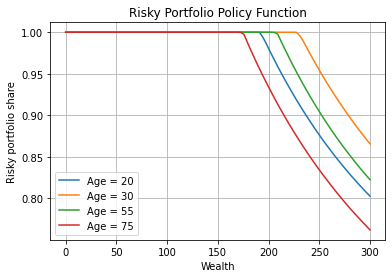

In [5]:
# Plot portfolio rule
eevalgrid = np.linspace(0,300,100)
plt.figure()
# In the last period of life you consume everything
# so portfolio choice is irrelevant

# Ages
ages = age_plot_params
age_born = time_params['Age_born']
for a in ages:
    plt.plot(eevalgrid,
             agent.solution[a-age_born].ShareFuncAdj(eevalgrid/norm_factor[a-age_born]),
             label = 'Age = %i' %(a))
plt.xlabel('Wealth')
plt.ylabel('Risky portfolio share')
plt.title('Risky Portfolio Policy Function')
plt.legend()
plt.grid()

if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)

We present the author's originally reported policy functions for comparison
<center><img src="Figures/Opt_shares_by_age.jpg" style="height:300px"></center>

#### Consumption behavior

The plot below shows the policy function for consumption as a function of wealth at different ages.

At all age levels consumption increases with wealth. The consumption function also appears to shift upwards as life progresses.

Our consumption policy functions again do not match those of the original paper, which are also reproduced below. Consumption also appears to increase with age in our policy functions that does not come through in the results presented in the paper. 

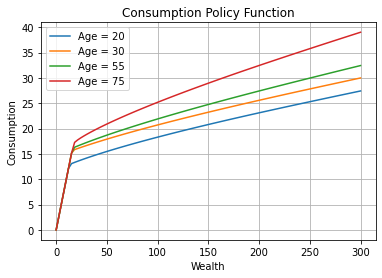

In [6]:
# Plot consumption function
plt.figure()
ages = age_plot_params
for a in ages:
    plt.plot(eevalgrid,
             agent.solution[a-age_born].cFuncAdj(eevalgrid/norm_factor[a-age_born])*norm_factor[a-age_born],
             label = 'Age = %i' %(a))
plt.xlabel('Wealth')
plt.ylabel('Consumption')
plt.title('Consumption Policy Function')
plt.legend()
plt.grid()

if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)

We again present the author's originally reported policy functions for comparison
<center><img src="Figures/Opt_cons_by_age.jpg" style="height:300px"></center>

### Simulations

Using the policy functions obtained from solving the model we present a series of simulations to highlight features of the model.

We first run a few simulations to verify the quality of our calibration.

The figures below show simulated levels of permanent income and risky portfolio shares for 5 agents over their life spans. We can see the model generates a heterogeneous permanent income distribution. Interestingly, all of these agents tend to follow the same general pattern for investing in the risky asset. Early in life, all of their portfolios are invested in the risky asset. This declines as the agent ages and converges to approximately 35% once they reach retirement.

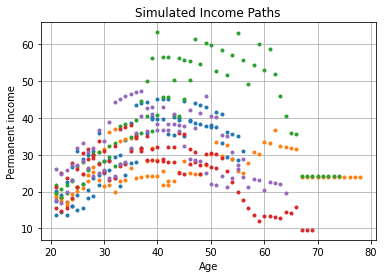

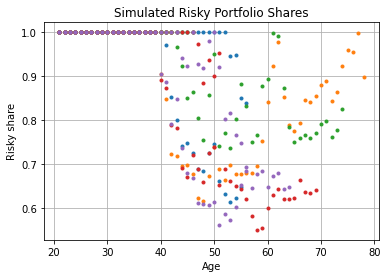

In [7]:
# Set up simulation parameters

# Number of agents and periods in the simulation.
agent.AgentCount = 5 # Number of instances of the class to be simulated.
# Since agents can die, they are replaced by a new agent whenever they do.

# Number of periods to be simulated
agent.T_sim = 80

# Set up the variables we want to keep track of.
agent.track_vars = ['aNrmNow','cNrmNow', 'pLvlNow', 't_age', 'ShareNow','mNrmNow']

# Run the simulations
agent.initializeSim()
agent.simulate()

# Present diagnostic plots.
plt.figure()
plt.plot(agent.history['t_age']+time_params['Age_born'], agent.history['pLvlNow'],'.')
plt.xlabel('Age')
plt.ylabel('Permanent income')
plt.title('Simulated Income Paths')
plt.grid()

if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)

plt.figure()
plt.plot(agent.history['t_age']+time_params['Age_born'], agent.history['ShareNow'],'.')
plt.xlabel('Age')
plt.ylabel('Risky share')
plt.title('Simulated Risky Portfolio Shares')
plt.grid()

if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)

#### The average life cycle patterns

We now increase the number of simulations to examine and compare the behavior of the mean values of variables of interest at different ages, conditional on survival. In each case we present the original plots from the paper for reference.

The plot below illustrates the average dynamics of permanent income, consumption, and market resources across all of the simulated agents. The plot follows the general pattern observed in the original paper. However, our results show that the agents are accumulating significantly more market resources. 

In [8]:
# Number of agents and periods in the simulation.
agent.AgentCount = 50 # Number of instances of the class to be simulated.
# Since agents can die, they are replaced by a new agent whenever they do.

# Number of periods to be simulated
agent.T_sim = 80*50

# Run the simulations
agent.initializeSim()
agent.simulate()

raw_data = {'Age': agent.history['t_age'].flatten()+time_params['Age_born'] - 1,
            'pIncome': agent.history['pLvlNow'].flatten(),
            'rShare': agent.history['ShareNow'].flatten(),
            'nrmM': agent.history['mNrmNow'].flatten(),
            'nrmC': agent.history['cNrmNow'].flatten()}

Data = pd.DataFrame(raw_data)
Data['Cons'] = Data.nrmC * Data.pIncome
Data['M'] = Data.nrmM * Data.pIncome

# Find the mean of each variable at every age
AgeMeans = Data.groupby(['Age']).mean().reset_index()

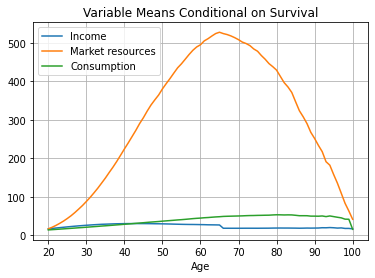

In [9]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome,
         label = 'Income')
plt.plot(AgeMeans.Age, AgeMeans.M,
         label = 'Market resources')
plt.plot(AgeMeans.Age, AgeMeans.Cons,
         label = 'Consumption')
plt.legend()
plt.xlabel('Age')
plt.title('Variable Means Conditional on Survival')
plt.grid()

if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)

<center><img src="Figures/ConsWInc.jpg" style="height:300px"></center>

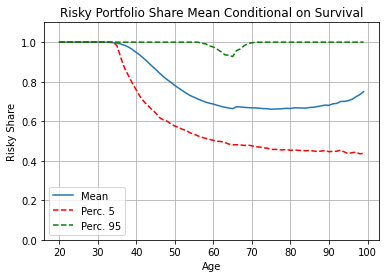

In [10]:
# Find age percentiles
AgePC5 = Data.groupby(['Age']).quantile(0.05).reset_index()
AgePC95 = Data.groupby(['Age']).quantile(0.95).reset_index()

# plot till death - 1  
age_1 = time_params['Age_death'] - time_params['Age_born']

plt.figure()
plt.ylim([0, 1.1])
plt.plot(AgeMeans.Age[:age_1], AgeMeans.rShare[:age_1], label = 'Mean')
plt.plot(AgePC5.Age[:age_1], AgePC5.rShare[:age_1], '--r', label='Perc. 5')
plt.plot(AgePC95.Age[:age_1], AgePC95.rShare[:age_1], '--g', label = 'Perc. 95')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Risky Share')
plt.title('Risky Portfolio Share Mean Conditional on Survival')
plt.grid()

if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)

<center><img src="Figures/ShareMeanSim.jpg" style="height:300px"></center>

### Other results in the original paper

#### The welfare implications of different allocation rules

The authors next conduct a welfare analysis of different allocation rules, including popular heuristics. The rules are presented in the next figure.

<center><img src="Figures/Alloc_rules.jpg" style="height:500px"></center>

The utility cost of each policy in terms of constant consumption streams with respect to the authors calculated optimal policy function is reported in the next table.

<center><img src="Figures/Util_cost.jpg" style="height:100px"></center>

Interestingly, the "no-income" column corresponds to the usual portfolio choice result of the optimal share being the quotient of excess returns and risk times relative risk aversion, disregarding labor income. The experiment shows this allocation produces substantial welfare losses.

#### Heterogeneity and sensitivity analysis

The authors also considered a number of extensions to the baseline model. These are summarized below along with their main conclusions.

- Labor income risk: Income risk may vary across employment sectors relative to the baseline model. The authors examine extreme cases for industries that have a large standard deviation and temporary income shocks. While some differences appear across sectors, the results are generally in line with the baseline model.
- Disastrous labor income shocks: The authors find that even a small probability of zero labor income lowers the optimal portfolio allocation in stocks, while the qualitative features of the baseline model are preserved.
- Uncertain retirement income: The authors consider two types of uncertainty for retirement income; it is stochastic and correlated with current stock market performance and allowing for disastrous labor income draws before retirement. The first extension has results essentially the same as the baseline case. The second leads to more conservative portfolio allocations but is broadly consistent with the baseline model.
- Endogenous borrowing constraints: The authors add borrowing to their model by building on credit-market imperfections. They find that the average investor borrows about \$5,000 and are in debt for most of their working life. The agents eventually pay off this debt and save for retirement. Relative to the benchmark model, the investor has put less of their money in their portfolio and arrive at retirement with substantially less wealth. These results are particularly pronounced at the lower end of the income distribution relative to the higher end. Additional details are available in the text.
- Bequest motive: The authors introduce a bequest motive into the agent's utility function (i.e., $b>0$). Young investors are more impatient and tend to save less for bequests. As the agent ages, savings increases and is strongest once the agent retires. This leads to effects on the agent's portfolio allocation. Taking a step-back however, these effects are not very large unless $b$ is large.
- Educational attainment: The authors generally find that savings are consistent across education groups. They note that for a given age, the importance of future income is increasing with education level. This implies that riskless asset holdings are larger for these households.
- Risk aversion and intertemporal substitution: Lowering the level of risk aversion in the model leads to changes in the optimal portfolio allocation and wealth accumulation. Less risk-averse investors accumulate less precautionary savings and invest more in risky assets.

### Conclusion

This article provides a dynamic model with accurate lifetime income profiles in which labor income increases risky asset holdings, as it is seen as a closer substitute of risk-free assets. It finds an optimal risky asset share that decreases in wealth and with age, after middle age. The model is also used to show that ignoring labor income for portfolio allocation can generate substantial welfare losses.

### Puzzles and Questions

- Table 4 says stock returns are $0.06$. They might mean that the equity premium $\mu$ is $0.06$.
- The authors report taking the normalization $v_{i,t} = 1$. However the ranges of their results seem more consistent with $v_{i,t} = 0$ so that $\exp (v_{i,t}) = 1$, which also makes more sense for interpretation.


### Robustness Analyses

Given the differences between our results and the original paper, we did a number of checks to ensure our model was behaving consistently with well-established theoretical results. Specifically we checked:
- For an infinitely lived agent with log normal returns, that their optimal portfolio allocation converges to the Campbell-Viceira (2002) approximation to the optimal portfolio share in Merton-Samuelson (1969) model.
- For an infinitely lived agent with no labor income that can only invest in a single risky asset, that their marginal propensity to consumer converges to the theoretical MPC of Merton-Samuelson (1969).
- For an agent facing no labor income risk, that their consumption patterns precisely match the results from a perfect foresight solution.

In all three cases, we verified that our HARK model holds up to these results. More details and specific results are available upon request. 

As the HARK toolkit continues to develop, there are additional sensitivities that we can perform to further check the credibility of our results. Specifically, once human wealth is available in the $\texttt{PortfolioConsumerType}$ class, we can perform the following additional checks, which were kindly suggested by Professor Sylvain Catherine:
- Shut down the income risk and remove retirement income. The solution to this new problem are provided by Merton 1971. Basically, you capitalize future earnings as an endowment of risk free asset. Then the equity share should be such that Equity/(Wealth+NPV of Human capital) is the same as the equity share in Merton 1969.
- Adding back the permanent income risk and check if the equity share is consistent with Viceira 2001. Viceira tells you something like this: $\pi = \frac{\mu - r}{\gamma \sigma^2_s} + \left(\frac{\mu - r}{\gamma \sigma^2_s} - \beta_{HC} \right) \frac{HC}{W}$, where $\beta_{HC} = \frac{\text{Cov}(r_{HC},r_s)}{\text{Var}(r_s)}$. In the CGM problem it is easy to compute $\beta_{HC}$ because earnings follow a simple random walk. HC is the NPV of human capital, which you can approximate very well by discounting expected earnings by $r+\beta_{HC}*(rm-r)$.

### Bibliographic entry of the original article

In [11]:
### Bibtex entry
'''
@article{10.1093/rfs/hhi017,
    author = {Cocco, João F. and Gomes, Francisco J. and Maenhout, Pascal J.},
    title = "{Consumption and Portfolio Choice over the Life Cycle}",
    journal = {The Review of Financial Studies},
    volume = {18},
    number = {2},
    pages = {491-533},
    year = {2005},
    month = {02},
    abstract = "{This article solves a realistically calibrated life cycle model of consumption and portfolio choice with non-tradable labor income and borrowing constraints. Since labor income substitutes for riskless asset holdings, the optimal share invested in equities is roughly decreasing over life. We compute a measure of the importance of human capital for investment behavior. We find that ignoring labor income generates large utility costs, while the cost of ignoring only its risk is an order of magnitude smaller, except when we allow for a disastrous labor income shock. Moreover, we study the implications of introducing endogenous borrowing constraints in this incomplete-markets setting.}",
    issn = {0893-9454},
    doi = {10.1093/rfs/hhi017},
    url = {https://doi.org/10.1093/rfs/hhi017},
    eprint = {http://oup.prod.sis.lan/rfs/article-pdf/18/2/491/24421441/hhi017.pdf},
}
'''

'\n@article{10.1093/rfs/hhi017,\n    author = {Cocco, João F. and Gomes, Francisco J. and Maenhout, Pascal J.},\n    title = "{Consumption and Portfolio Choice over the Life Cycle}",\n    journal = {The Review of Financial Studies},\n    volume = {18},\n    number = {2},\n    pages = {491-533},\n    year = {2005},\n    month = {02},\n    abstract = "{This article solves a realistically calibrated life cycle model of consumption and portfolio choice with non-tradable labor income and borrowing constraints. Since labor income substitutes for riskless asset holdings, the optimal share invested in equities is roughly decreasing over life. We compute a measure of the importance of human capital for investment behavior. We find that ignoring labor income generates large utility costs, while the cost of ignoring only its risk is an order of magnitude smaller, except when we allow for a disastrous labor income shock. Moreover, we study the implications of introducing endogenous borrowing const